In [30]:
import pyqir_parser as pqp
import matplotlib.pyplot as plt
import networkx as nx
from pyvis import network as net

In [1]:
from qwop.visualization import *

AttributeError: partially initialized module 'qwop.exporters.interface' has no attribute 'CircuitLikeExporter' (most likely due to a circular import)

In [2]:
#mod = pqp.QirModule("bernstein_vazirani.bc")
mod = pqp.QirModule("teleportchain.baseprofile.bc")
func_name = "TeleportChain__DemonstrateTeleportationUsingPresharedEntanglement__Interop"
func = mod.get_func_by_name(func_name)

## NetworkX Graph Construction

In [41]:
# Need a way of telling if a block has quantum instructions.
# This is probably wrong as written rn, may want to filter further.
def is_block_quantum(block : pqp.QirBlock) -> bool:
    return any(
        isinstance(instruction, pqp.QirQisCallInstr) 
        for instruction in block.instructions
    )

# Adds metadata as a dict to a node derived from a block's contents.
def qir_block_style(block : pqp.QirBlock) -> dict:
    return {
        "node_color" : "red" if is_block_quantum(block) else "blue",
        "node_name" : block.name,
        "is_endpoint" : block.name == 'entry'
    }

# Pyvis expects node labels to be strings, so this just makes a new copy
# of a graph and replaces the nodes keyed with `QirBlock` to the 
# name property of the block
def graph_to_pyvis(graph : "nx.MultiDiGraph") -> "nx.MultiDiGraph":
    new_graph = graph.copy()
    mapping = {block: data["node_name"] for block, data in new_graph.nodes(data=True)}
    return nx.relabel_nodes(new_graph, mapping)

#get a dict of edges : edge label simplified by truncation
def graph_edge_labels_simple(graph : "nx.MultiDiGraph") -> dict:
    return {(e1, e2): data["cond"] for e1, e2, data in graph.edges(data=True)}

# Generates a NetworkX graph corrisponding to the blocks in 
# PyQIR function.
def control_flow_graph_netx(func : pqp.QirFunction) -> "nx.MultiDiGraph":
    cfg = nx.MultiDiGraph()
    blocks_by_name = {} 
    for block in func.blocks:
        cfg.add_node(block, **qir_block_style(block))
        blocks_by_name[block.name] = block
    
    return_node = "return"
    bottom_node = None
    
    cfg.add_node(return_node, **{
        "node_color" : "blue",
        "node_name" : return_node,
        "is_endpoint" : True
    })

    for block in blocks_by_name.values():
        term = block.terminator
        if isinstance(term, pqp.QirCondBrTerminator):
            cfg.add_edge(block, blocks_by_name[term.true_dest], cond="True")
            cfg.add_edge(block, blocks_by_name[term.false_dest], cond="False")
        elif isinstance(term, pqp.QirBrTerminator):
            cfg.add_edge(block, blocks_by_name[term.dest], cond="()")
        elif isinstance(term, pqp.QirRetTerminator):
            cfg.add_edge(block, return_node, cond="()")
        elif isinstance(term, pqp.QirSwitchTerminator):
            print(f"Not yet implemented: {term} in {block}")
        elif isinstance(term, pqp.QirUnreachableTerminator):
            if bottom_node is None:
                bottom_node = "⊥"
            cfg.add_edge(block, bottom_node)
        else:
            print(f"Not yet implemented: {term} in {block}")

    return cfg

Let's make a graph of Teleport!

In [6]:
F = control_flow_graph_netx(func)
labels={n: getattr(n, "name", n)[:12] for n in F.nodes}
print(F)

MultiDiGraph with 10 nodes and 13 edges


Using MatPlotLib we can use the graph above to make static plots of the graph with some of the node information.
Here we also color the nodes based on whether the block contains quantum operations.

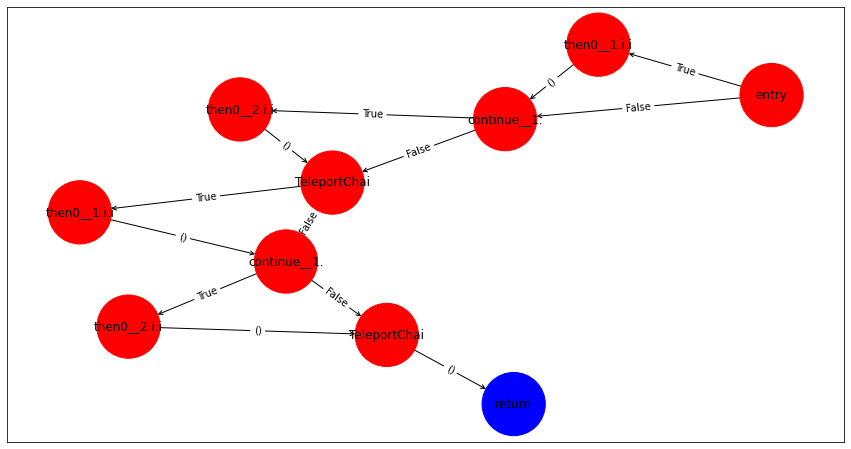

In [44]:
fig, ax = plt.subplots(figsize=(15, 8))
pos = nx.kamada_kawai_layout(F)
nx.draw_networkx(
    F, 
    pos=pos,
    ax=ax,
    labels=labels,
    arrowstyle="->",
    min_source_margin=15,
    min_target_margin=15,
    node_size=4000,
    node_color= [v["node_color"] for n, v in F.nodes.items()])
#nx.draw_networkx_edge(G, pos=pos, ax=ax)
nx.draw_networkx_edge_labels(F, pos=pos, ax=ax, edge_labels={(e1, e2): data["cond"] for e1, e2, data in F.edges(data=True)})
plt.show()

Next, we want to try an interactive graph with PyVis:

In [45]:
#nt = net.Network('500px', '500px') #, notebook=True
nt = net.Network('500px', '500px', notebook=True)
nt.from_nx(H)
#nt.show_buttons()
nt.show('nx.html')


## Notes on PyQIR classes

https://towardsdatascience.com/customizing-networkx-graphs-f80b4e69bedf tutorial on graph styling

class QirRetTerminator(QirTerminator):
    """
    Instances of QirRetTerminator represent the ret instruction in a QIR program.
    """

class QirBrTerminator(QirTerminator):
    """
    Instances of QirBrTerminator represent a branch terminator instruction that unconditionally
    jumps execution to the named destination block.
    """

class QirCondBrTerminator(QirTerminator):
    """
    Instances of QirCondBrTerminator represent a conditional branch terminator instruction that
    decides which named block to jump to based on an given operand.
    """

class QirSwitchTerminator(QirTerminator):
    """
    Instances of QirSwitchTerminator represent a switch terminator instruction that can jump
    to one or more blocks based on matching values of a given operand, or jump to a fallback block
    in the case that no matches are found.
    """

class QirUnreachableTerminator(QirTerminator):
    """
    Instances of QirUnreachableTerminator represent an unreachable terminator instruction. As the name
    implies, this terminator is not expected to be reached such that some instruction in the block
    before this terminator should halt program execution.
    """

#### Other useful links
- https://towardsdatascience.com/making-network-graphs-interactive-with-python-and-pyvis-b754c22c270
- https://towardsdatascience.com/pyvis-visualize-interactive-network-graphs-in-python-77e059791f01
- https://visjs.github.io/vis-network/examples/
- https://visjs.github.io/vis-network/examples/network/exampleApplications/disassemblerExample.html
    